<h1>Toronto Neighborhoods Assignment</h1>

<b> Important note </b> : all three problems are done in this single notebook

<h2> Part 1 : scrap data from wikipedia </h2>

In [130]:
!pip install bs4
!pip install wikipedia

We use urlopen to open the url anf BeautifulSoup to parse the html page, looking for tables

In [143]:
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
from urllib.request import urlopen

url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
html = urlopen(url) 
soup = BeautifulSoup(html, 'html.parser')

soup = soup.find_all('table')

The 3 columns of the table are in order : PostalCode, Borough & Neighborhood.

Each row is under the 'tr' tag, and each cell of the row is under the 'td' tag.

A condition is added to skeep the 'Not assigned' boroughs

The text of each column is retrieved, changing the separator / by a comma in case of multiple neighborhoods in one borough

We asssume the last 5 rows are part of the last table of the html page which is not in the scope of the study, so we remove them.

In [144]:
postal_codes = []
boroughs = []
neighborhoods = []

for table in soup:
    rows = table.find_all('tr')
    
    for row in rows:
        cells = row.find_all('td')
        
        
        if len(cells) > 1:
            
            if (len(cells) > 2 and cells[1].text.strip() != "Not assigned"):
                postal_code = cells[0]
                postal_codes.append(postal_code.text.strip())

                borough = cells[1]
                boroughs.append(borough.text.strip())

                neighborhood = cells[2].text.strip()
                neighborhood = neighborhood.replace(" / ", ", ")
                neighborhoods.append(neighborhood)

                
postal_codes = postal_codes[:-5]
boroughs = boroughs [:-5]
neighborhoods = neighborhoods [:-5]

We create a dictionnary to store the data, label the columns, and then transform it into a pandas dataframe.

In [148]:
dic = {'PostalCode' : postal_codes, 'Borough' : boroughs, 'Neighborhood' : neighborhoods}
df1 = pd.DataFrame(dic)
df1.head(10)

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
5,M9A,Etobicoke,Islington Avenue
6,M1B,Scarborough,"Malvern, Rouge"
7,M3B,North York,Don Mills
8,M4B,East York,"Parkview Hill, Woodbine Gardens"
9,M5B,Downtown Toronto,"Garden District, Ryerson"


<h2> Part 2 : Getting Latitude & Longitude of the boroughs </h2> 

I was not able to retrieve the coordinate with geocoder, so I used the csv file instead...

In [149]:
df_coord = pd.read_csv('Geospatial_Coordinates.csv')
df_coord.columns = ['PostalCode', 'Latitude', 'Longitude']
df_coord

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476
...,...,...,...
98,M9N,43.706876,-79.518188
99,M9P,43.696319,-79.532242
100,M9R,43.688905,-79.554724
101,M9V,43.739416,-79.588437


In [154]:
df_merge = pd.merge(df1, df_coord, on='PostalCode', how='outer')
df_merge

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
...,...,...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road , Old Mill North",43.653654,-79.506944
99,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
100,M7Y,East Toronto,Business reply mail Processing CentrE,43.662744,-79.321558
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509


<h2> Part 3 : Clustering Neighborhoods in Toronto </h2>

Extracting boroughs of toronto, i.e. containing the word Toronto

In [163]:
toronto_data = df_merge[df_merge['Borough'].str.contains("Toronto")].reset_index(drop=True)
toronto_data.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,M4E,East Toronto,The Beaches,43.676357,-79.293031


Retrieving Toronto coordinates to plot a map later on

In [166]:
geolocator = Nominatim(user_agent="foursquare_agent")
city = 'Toronto, Canada'
location = geolocator.geocode(city)
lat_toronto = location.latitude
lng_toronto = location.longitude
print(city, lat, lng)

Toronto, Canada 43.6534817 -79.3839347


Visualize the boroughs of Toronto

In [167]:
#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

# create map of Manhattan using latitude and longitude values
map_toronto = folium.Map(location=[lat_toronto, lng_toronto], zoom_start=11)

# add markers to map
for lat, lng, label in zip(toronto_data['Latitude'], toronto_data['Longitude'], toronto_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

Defining FourSquare Credentials

In [168]:
CLIENT_ID = 'SZUGSK0EFWDBUW3WC3VXPDZKYSVFVCDQIVKH0UPZF0QRRQSS' # your Foursquare ID
CLIENT_SECRET = 'KWGAIPBDPY3WX1A3WXWYGJ4GJZDKDHKFEN1HX1H0MWOUDGNA' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: SZUGSK0EFWDBUW3WC3VXPDZKYSVFVCDQIVKH0UPZF0QRRQSS
CLIENT_SECRET:KWGAIPBDPY3WX1A3WXWYGJ4GJZDKDHKFEN1HX1H0MWOUDGNA


In [169]:
import random # library for random number generation
import numpy as np # library for vectorized computation
import matplotlib.pyplot as plt # plotting library
from sklearn.cluster import KMeans 

Function to extract venues of each neighborhood

In [192]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        #print(requests.get(url).json()["response"]["groups"])
        results = requests.get(url).json()["response"]["groups"][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [173]:
toronto_venues = getNearbyVenues(names=toronto_data['Neighborhood'],
                                   latitudes=toronto_data['Latitude'],
                                   longitudes=toronto_data['Longitude']
                                  )

Regent Park, Harbourfront
Queen's Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
The Danforth West, Riverdale
Toronto Dominion Centre, Design Exchange
Brockton, Parkdale Village, Exhibition Place
India Bazaar, The Beaches West
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West
High Park, The Junction South
North Toronto West
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
University of Toronto, Harbord
Runnymede, Swansea
Moore Park, Summerhill East
Kensington Market, Chinatown, Grange Park
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Rosedale
Stn A PO Boxes
St. James Town,

In [179]:
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park, Harbourfront",43.65426,-79.360636,Morning Glory Cafe,43.653947,-79.361149,Breakfast Spot
3,"Regent Park, Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
4,"Regent Park, Harbourfront",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa


Couting the venues for each neighborhood

In [175]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berczy Park,55,55,55,55,55,55
"Brockton, Parkdale Village, Exhibition Place",24,24,24,24,24,24
Business reply mail Processing CentrE,16,16,16,16,16,16
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",16,16,16,16,16,16
Central Bay Street,60,60,60,60,60,60
Christie,16,16,16,16,16,16
Church and Wellesley,77,77,77,77,77,77
"Commerce Court, Victoria Hotel",100,100,100,100,100,100
Davisville,33,33,33,33,33,33


In [177]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 228 uniques categories.


Separating the venues using one hot encoding

In [187]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues['Venue Category'], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,...,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [188]:
toronto_onehot.shape

(1604, 228)

Grouping rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [189]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Yoga Studio,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store
0,Berczy Park,0.000000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.00,0.018182,0.000000,0.000000,0.000000,0.000000
1,"Brockton, Parkdale Village, Exhibition Place",0.000000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
2,Business reply mail Processing CentrE,0.000000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000,0.0625,0.0625,0.0625,0.125,0.1875,0.125,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
4,Central Bay Street,0.016667,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.00,0.016667,0.000000,0.000000,0.000000,0.000000
5,Christie,0.000000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
6,Church and Wellesley,0.025974,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.012987,0.000000,...,0.012987,0.012987,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
7,"Commerce Court, Victoria Hotel",0.000000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.040000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.00,0.020000,0.000000,0.000000,0.010000,0.000000
8,Davisville,0.000000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.000000,0.000000,...,0.000000,0.000000,0.030303,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
9,Davisville North,0.000000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000


Confirming new size

In [191]:
toronto_grouped.shape

(39, 228)

Function to sort the venues and return the most commons ones

In [193]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Creating the dataframe and displaying the 10 most common venues

In [211]:
num_top_venues = 10
indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Cocktail Bar,Beer Bar,Bakery,Seafood Restaurant,Restaurant,Cheese Shop,Café,Jazz Club,Shopping Mall
1,"Brockton, Parkdale Village, Exhibition Place",Nightclub,Café,Breakfast Spot,Coffee Shop,Climbing Gym,Bar,Stadium,Bakery,Intersection,Italian Restaurant
2,Business reply mail Processing CentrE,Park,Auto Workshop,Comic Shop,Pizza Place,Recording Studio,Burrito Place,Restaurant,Brewery,Light Rail Station,Smoke Shop
3,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Service,Airport Lounge,Airport Terminal,Boat or Ferry,Harbor / Marina,Boutique,Bar,Coffee Shop,Sculpture Garden,Airport
4,Central Bay Street,Coffee Shop,Italian Restaurant,Sandwich Place,Café,Burger Joint,Bar,Ice Cream Shop,Salad Place,Thai Restaurant,Bubble Tea Shop


<h4> K-Means</h4>

Running K-Means to cluster the neighborhoods in 10 clusters

In [212]:
kclusters = 10

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 8, 1, 0, 1, 8, 1, 1, 1, 7], dtype=int32)

Creating new dataframe including the cluster

In [213]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # check the last columns!

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,1,Coffee Shop,Bakery,Pub,Park,Café,Breakfast Spot,Theater,Ice Cream Shop,Chocolate Shop,Spa
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,1,Coffee Shop,Sushi Restaurant,Diner,Yoga Studio,Creperie,Sandwich Place,Burger Joint,Burrito Place,Café,Park
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,1,Coffee Shop,Clothing Store,Café,Middle Eastern Restaurant,Restaurant,Japanese Restaurant,Bubble Tea Shop,Cosmetics Shop,Ramen Restaurant,Bookstore
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,1,Café,Coffee Shop,Cocktail Bar,Gastropub,American Restaurant,Hotel,Creperie,Lingerie Store,Department Store,Moroccan Restaurant
4,M4E,East Toronto,The Beaches,43.676357,-79.293031,9,Health Food Store,Coffee Shop,Pub,Trail,Women's Store,Deli / Bodega,Department Store,Dessert Shop,Diner,Distribution Center


In [214]:
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[lat_toronto, lng_toronto], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

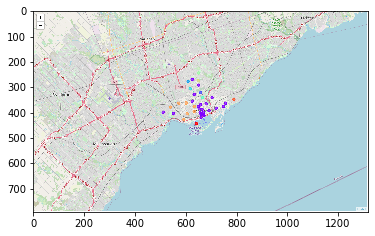

In [215]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread('toronto_clustered.png')
imgplot = plt.imshow(img)
plt.show()